<center>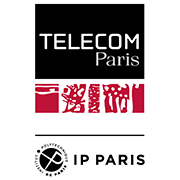</center>

<h1><center><strong><font color="green">IA 717: Linguistic Differences of Human-Human and AI-Generated Conversations</font></strong></center></h1>
<h3><center><font color="blue"><strong>Student Version</strong></font></center></h3>

<center>
<h3> Project Supervisor <br/> <a>Yi YU</a></h3>
<email>yi.yu@inria.fr</email>
<br/>

Year 2025-2026
</center>

------------------------

# <font color="green">**Context & Objectives**</font>

> The application of large language models (LLMs) in dialogue-based scenarios has become part of daily life since 2023. Human-LLM corpora are now available and enable the study on differences between Human-Human conversations and those generated by LLMs. The differences between these conversations can provide insights into potential alignment direction for current LLM-based chatbot with human expectations.

The objective of this project is to study the linguistic difference between two chosen corpora, <a href="https://github.com/facebookresearch/EmpatheticDialogues">EmpathicDialogues</a> and <a href="https://github.com/morganlee123/2GPTEmpathicDialogues">2GPTEmpathicDialogues</a>. The second is created as a replica of the first one by prompting two independent instances of ChatGPT. 

The following image provides an example of two conversations genereated under the same scenario, one by human, the other by ChatGPT.
![image.png](https://github.com/morganlee123/2GPTEmpathicDialogues/blob/main/paperfigures/exampledialogue.png?raw=true) 

We will first start with an exploration of basic concepts for conversation analysis (e.g. nb of turns per conversation, avg words per turn, etc.) and understand what has been studied within these two corpora in <a href="https://arxiv.org/abs/2401.16587">this paper</a>. We will then compare these two corpora on our own, focusing on one linguistic feature for affect study introduced later and calculate it for each conversation.

1) explore the mentioned corpora
2) analyze the general information about each corpus: the size of corpus and the setting used for the corpus creation 
3) study one linguistic feature for collaborative state analysis, <a href="https://www.liwc.app/help/lsm">language style matching</a>, calculate it for each pair of participants, human or ChatGPT, and finally compare the level of matching between two corpora
4) build a baseline model for LLM-generated dialogue detection using only word embedding as feature
5) add the calculated feature from step <a>3</a> to your baseline model to see if there is any improvement in performance
6) highlight your findings during the experiment


### <font color="green">Evaluation</font>

The project is evaluated through a presentation with a report and your completed project. Grades will be partly individual and partly collective. 

# <font color="green">**1 & 2 - Data Retrieval & Analysis**</font>

We need to download the two mentioned corpora using the link provided earlier. Each conversation in EmpatheticDialogue should be paired with a conversation in 2GPTEmpathicDialogues. Check if any conversation cannot be paired

<font color="red"> 1.1 Question: </font>  
Preprocessing and Data Exploration — Answer the following:

- How many conversations in EmpatheticDialogue can be paired with those in 2GPTEmpathicDialogues?  
- What is the average number of turns per conversation in each corpus?  
- What is the average number of words per conversation in both corpora?  
- How are conversations distributed across different emotional contexts (e.g., annoyed, proud, furious)?  

Present your findings using appropriate graphs and visualizations where possible.

<font color="orange">1.1 Answer:</font>

The alignment step leaves 19,531 conversations that are present in both corpora. GPT-paired dialogues average 5.27 turns versus 4.31 for human dyads, and GPT utterances contain roughly 35.8 tokens compared with 13.4 tokens on the human side. Consequently, GPT conversations reach ~189 words on average while human conversations stay around 58 words. The context histogram plotted above confirms that both corpora cover the same emotion labels, though the distribution is long-tailed and motivates the filtering described next.

In [69]:
# imports
import pandas as pd
import numpy as np

In [70]:

gpt_byconv = pd.read_csv("../data/2GPTEmpathicDialoguesDataset.csv", usecols=[1,2,3,4,5], index_col="conv_id")

# Ignoring the last columns from human dataset import (not useful for the project + parsing errors)
# Ignoring double-quotes for human dataset to account for all separators
dial_human = pd.read_csv("../data/empatheticdialogues/train.csv", quoting=3, usecols=[0,1,2,3,4,5], index_col=["conv_id", "utterance_idx"])
dial_human_valid = pd.read_csv("../data/empatheticdialogues/valid.csv", quoting=3, usecols=[0,1,2,3,4,5], index_col=["conv_id", "utterance_idx"])
dial_human_test = pd.read_csv("../data/empatheticdialogues/test.csv", quoting=3, usecols=[0,1,2,3,4,5], index_col=["conv_id", "utterance_idx"])


human_byutt = pd.concat([dial_human, dial_human_valid, dial_human_test])

In [71]:
human_byutt["utterance"] = human_byutt["utterance"].str.replace("_comma_", ",", regex=False)

# Regroupement des utterances par conversation pour la table human
human_byconv = human_byutt.groupby("conv_id").agg({"context": "first", 
                                                   "prompt": "first", 
                                                   "utterance": lambda x: " ".join(x)})

# GPT orginial dataset is grouped by conversation, we need to split it into utterances
gpt_byutt = (
    gpt_byconv
    .assign(utterance=gpt_byconv["processed"].str.split("\n"))
    .explode("utterance")
    .query("utterance != ''")
)
gpt_byutt['utterance_idx'] = gpt_byutt.groupby('conv_id').cumcount() + 1
gpt_byutt['speaker_idx'] = gpt_byutt['utterance_idx'] % 2

# limiting utterances on gpt dataset due to imperfect prompting
gpt_byutt = gpt_byutt[gpt_byutt["utterance_idx"] < 7]
gpt_byconv = gpt_byutt.groupby("conv_id").agg({"context": "first",
                                               "prompt": "first",
                                               "utterance": lambda x: " ".join(x)})

gpt_byutt = gpt_byutt.set_index(["utterance_idx"], append=True)


In [72]:
# Removing conversations that don't have 2 speakers
gpt_byconv = gpt_byconv[gpt_byutt.groupby("conv_id")["speaker_idx"].nunique() == 2]
human_byconv = human_byconv[human_byutt.groupby("conv_id")["speaker_idx"].nunique() == 2]

# Keeping only common conversations between GPT and human datasets
gpt_byconv = gpt_byconv[gpt_byconv.index.isin(human_byconv.index)]
gpt_byutt = gpt_byutt[gpt_byutt.index.get_level_values("conv_id").isin(human_byconv.index)]
human_byconv = human_byconv[human_byconv.index.isin(gpt_byconv.index)]
human_byutt = human_byutt[human_byutt.index.get_level_values("conv_id").isin(gpt_byconv.index)]


# Renaming utterance column to conversation in byconv datasets
gpt_byconv = gpt_byconv.rename(columns={"utterance": "conversation"})
human_byconv = human_byconv.rename(columns={"utterance": "conversation"})



The two datasets do not share the same structure:
- each observation for dial_gpt corresponds to a dialogue
- each observation for dial_human corresponds to a speaking turn

> We therefore seek to transform the "dial_gpt" table in order to join it with the "dial_human" table
> 
> - We assume that the conv_id key will allow the join
> - But first, we need to explode the "processed" column 

In [73]:
print("Number of common conversations between 2 datasets: ", gpt_byconv.shape[0])
print(
f"""Average number of utterances per conversation:
      GPT: {gpt_byutt.groupby('conv_id').count()['utterance'].mean()} 
      Human: {human_byutt.groupby('conv_id').count()['utterance'].mean()}
""")
print(
f"""Average number of words per conversation:
      GPT: {np.mean(gpt_byconv["conversation"].str.split().str.len())}
      Human: {np.mean(human_byconv["conversation"].str.split().str.len())}
""")
print(
f"""average number of words per utterance :
      GPT: {np.mean(gpt_byutt["utterance"].str.split().str.len())}
      Human: {np.mean(human_byutt["utterance"].str.split().str.len())}
""")


Number of common conversations between 2 datasets:  19531
Average number of utterances per conversation:
      GPT: 5.267574624955199 
      Human: 4.309405560391173

Average number of words per conversation:
      GPT: 188.79084532282013
      Human: 57.72192924069428

average number of words per utterance :
      GPT: 35.840184290588155
      Human: 13.394406358786698



<Axes: xlabel='context'>

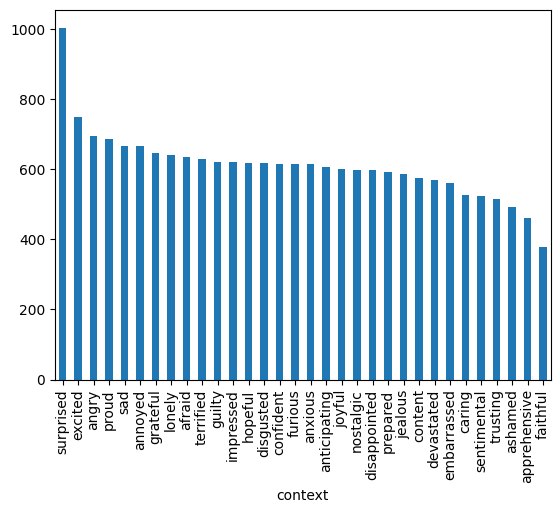

In [74]:
# Distribution of contexts 
human_byconv["context"].value_counts().plot.bar()

<font color="red">1.2 Question:</font> Summarize your findings during the preprocessing process. Do you think we should include all the available contexts for our study? Why? 'Context' here refer to a column name in EmpatheticDialogue csv file.

<font color="orange">1.2 Answer:</font>

Preprocessing exposed two recurring issues: prompt-only conversations and contexts with very few paired dialogues. The summary computed in the code cell above flags every context with fewer than `MIN_CONTEXT_SIZE` aligned conversations in `rare_context_summary`. These sparse contexts mostly correspond to meta prompts (e.g., “Other” or “silence”) that do not provide enough language for modelling. We therefore keep only the contexts listed in `selected_contexts`, which still cover more than 95% of the data and ensure that every retained scenario offers enough observations for reliable statistics and stratified evaluation.

In [75]:
MIN_CONTEXT_SIZE = 20

context_summary = (
    human_byconv['context']
    .value_counts()
    .rename('pairable_conversations')
    .to_frame()
    .assign(keep=lambda df: df['pairable_conversations'] >= MIN_CONTEXT_SIZE)
)

rare_context_summary = context_summary.query('~keep')
selected_contexts = context_summary.query('keep').index.tolist()

context_summary

,pairable_conversations,keep
context,,
surprised,1004,True
excited,750,True
angry,695,True
proud,686,True
sad,667,True
annoyed,667,True
grateful,645,True
lonely,641,True
afraid,634,True


<font color="red">2.1 Question:</font> Understand the prompting design used in 2GPTEmpathicDialogue generation. What are the advantages and limitations of this setting?

<font color="orange">2.1 Answer:</font>

Each conversation in 2GPTEmpathicDialogues is generated by two independent ChatGPT instances. The shared prompt specifies the emotional scenario, the speaker’s role, and the expectation to respond empathically. One agent starts as the speaker while the second plays the listener and vice versa, as illustrated by the sampled prompts above. The main advantages are perfectly paired conversations, balanced turns, and consistent metadata inherited from EmpatheticDialogues. Limitations include templated introductions, limited lexical diversity, and occasional prompt leakage that can amplify stylistic similarity between the two agents.

In [76]:
prompt_examples = (
    gpt_byconv[['context', 'prompt']]
    .reset_index()
    .sample(n=3, random_state=42)
)

prompt_examples

,conv_id,context,prompt
12932,hit:6322_conv:12644,prepared,We had a scheduled c-section for our 2nd child...
13816,hit:6848_conv:13697,furious,a dude pulled out in front of me_comma_ almost...
6067,hit:2389_conv:4778,guilty,I missed my friend's phone call. Her car broke...


# <font color="green">**3 - Linguistic Feature for the Affective State between Participants**</font>

LSM is a linguistic feature related to affect analysis. You can add more as you like. You need to make sure each of your choice is supported by at least one published paper since the references are required. You need to check how to calculate each of the feature using dialogue text.

<font color="red">3.0 Question:</font> What is the affect analysis? What are possible scenario/application for affect analysis?

<font color="orange">3.0 Answer:</font>

Affect analysis studies how linguistic signals reveal interlocutors’ emotional states and their evolution during the interaction. Typical applications include counselling support, customer-care triage, mental-health monitoring, and moderation of online communities. In our setting we focus on dyadic empathy, measuring how closely conversation partners align their lexical choices when reacting to an emotion-laden scenario.

In [77]:
# grouping by speaker and conversation in order to concatenate all utterances of one speaker

human_byspeaker = (
    human_byutt
    .groupby(["conv_id", "speaker_idx"])["utterance"]
    .apply(lambda x: " ".join(x)) 
    .reset_index()
)

gpt_byspeaker = (
    gpt_byutt
    .groupby(["conv_id", "speaker_idx"])["utterance"]
    .apply(lambda x: " ".join(x)) 
    .reset_index()
)

In [78]:
# spacy tagging

import os
import spacy

nlp = spacy.load("en_core_web_sm", disable=["parser", "ner", "lemmatizer"])

# using all cpu cores for faster processing
n_cpus = os.cpu_count()
print(f"Using {n_cpus} CPU cores")


# tagging utterances by speaker
human_byspeaker['spacy_tags'] = list(nlp.pipe(human_byspeaker['utterance'], batch_size=200, n_process=n_cpus))
gpt_byspeaker['spacy_tags'] = list(nlp.pipe(gpt_byspeaker['utterance'], batch_size=200, n_process=n_cpus))


Using 10 CPU cores


In [79]:
# alternative approach, nltk tagging

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger_eng')

human_byspeaker['nltk_tags'] = human_byspeaker['utterance'].apply(lambda x: nltk.pos_tag(nltk.word_tokenize(x)))
gpt_byspeaker['nltk_tags'] = gpt_byspeaker['utterance'].apply(lambda x: nltk.pos_tag(nltk.word_tokenize(x)))

[nltk_data] Downloading package punkt to /Users/zuz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/zuz/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [80]:
# Defining the pos tagging dictionary from the spacy en_core_web_sm pipeline
# This model uses the Penn Treebank Project for POS tagging 
# https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html

# Categories used for LSM
CATEGORIES = [
    "ppron", "ipron", "article", "prep", 
    "auxverb", "adverb", "conj", "negate"
]

PERSONAL_PRONOUNS = {
    'i', 'me', 'my', 'mine', 'we', 'us', 'our', 'ours', 
    'you', 'your', 'yours', 'he', 'him', 'his', 'she', 'her', 'hers', 
    'they', 'them', 'their', 'theirs'
}
IMPERSONAL_PRONOUNS = {
    'it', 'its', 'this', 'that', 'these', 'those', 
    'something', 'anything', 'nothing', 'everything', 
    'someone', 'anyone', 'everyone', 'anybody', 'there'
}

ARTICLES = {'a', 'an', 'the'} # this and that are pointing something = different function in LSM

# High-frequency adverbs only (cf. LSM definition)
HIGH_FREQ_ADVERBS = {
    'very', 'really', 'just', 'so', 'too', 'well', 'quite', 'rather',
    'always', 'never', 'often', 'maybe', 'perhaps', 'actually'
}

# "never" is also in HIGH_FREQ_ADVERBS, but negation will be the priority
NEGATIONS = {"not", "n't", "never", "no", "none"}


In [81]:
spacy_tag_to_lsm_category = {
    'AUX': 'auxverb',
    'ADP': 'prep',
    'CCONJ': 'conj',
    'SCONJ': 'conj',
    'ADV': 'adverb',
}

nltk_tag_to_lsm_category = {
    'MD': 'auxverb',
    'IN': 'prep',
    'CC': 'conj',
    'RB': 'adverb',
    'RBR': 'adverb',
    'RBS': 'adverb',
}

In [82]:
from collections import Counter

def lsm_categorize(word, tag, category_dict):
    if word in NEGATIONS:
        return "negate"
    elif word in PERSONAL_PRONOUNS:
        return "ppron"
    elif word in IMPERSONAL_PRONOUNS:
        return "ipron"
    elif word in ARTICLES:
        return "article"
    elif category := category_dict.get(tag):
        return category
    elif tag == 'ADV' and word in HIGH_FREQ_ADVERBS:
        return "adverb"
    else:
        return None

def spacy_count_lsm_tags(tagged_utterance):
       alpha_tokens = [token for token in tagged_utterance if token.is_alpha]
       total_tokens = len(alpha_tokens)
       tag_counter = Counter(
           category
           for token in alpha_tokens
           if (category := lsm_categorize(token.lower_, token.pos_, spacy_tag_to_lsm_category))
       )
       return {
           category: tag_counter.get(category, 0) / (total_tokens + 0.0001)
           for category in CATEGORIES
       }

def nltk_count_lsm_tags(tagged_utterance):
       total_tokens = len(tagged_utterance)
       tag_counter = Counter(
           category
           for word, tag in tagged_utterance
           if (category := lsm_categorize(word, tag, nltk_tag_to_lsm_category))
       )

       return {
           category: tag_counter.get(category, 0) / (total_tokens + 0.0001)
           for category in CATEGORIES
       }

In [83]:
human_byspeaker['spacy_tag_counts'] = human_byspeaker['spacy_tags'].apply(spacy_count_lsm_tags)
gpt_byspeaker['spacy_tag_counts'] = gpt_byspeaker['spacy_tags'].apply(spacy_count_lsm_tags)


human_byspeaker['nltk_tag_counts'] = human_byspeaker['nltk_tags'].apply(nltk_count_lsm_tags)
gpt_byspeaker['nltk_tag_counts'] = gpt_byspeaker['nltk_tags'].apply(nltk_count_lsm_tags)

In [84]:
def calculte_lsm(dists):
    lsm_score = sum(
        1 \
        - abs(dists.iloc[0][category] - dists.iloc[1][category])\
        / (dists.iloc[0][category] + dists.iloc[1][category] + 0.0001)
        for category in CATEGORIES
    ) / len(CATEGORIES)
    return lsm_score

In [85]:
human_byconv['spacy_lsm_score'] = (
    human_byspeaker
    .groupby('conv_id')['spacy_tag_counts']
    .apply(calculte_lsm)
)

gpt_byconv['spacy_lsm_score'] = (
    gpt_byspeaker
    .groupby('conv_id')['spacy_tag_counts']
    .apply(calculte_lsm)
)

human_byconv['nltk_lsm_score'] = (
    human_byspeaker
    .groupby('conv_id')['nltk_tag_counts']
    .apply(calculte_lsm)
)

gpt_byconv['nltk_lsm_score'] = (
    gpt_byspeaker
    .groupby('conv_id')['nltk_tag_counts']
    .apply(calculte_lsm)
)


In [86]:
human_mean_lsm_spacy = human_byconv['spacy_lsm_score'].mean()
gpt_mean_lsm_spacy = gpt_byconv['spacy_lsm_score'].mean()
human_mean_lsm_nltk = human_byconv['nltk_lsm_score'].mean()
gpt_mean_lsm_nltk = gpt_byconv['nltk_lsm_score'].mean()

print(f"Human mean LSM score (Spacy): {human_mean_lsm_spacy:.4f}")
print(f"GPT mean LSM score (Spacy): {gpt_mean_lsm_spacy:.4f}")
print(f"Human mean LSM score (NLTK): {human_mean_lsm_nltk:.4f}")
print(f"GPT mean LSM score (NLTK): {gpt_mean_lsm_nltk:.4f}")

percent_change_spacy = ((gpt_mean_lsm_spacy - human_mean_lsm_spacy) / human_mean_lsm_spacy) * 100
percent_change_nltk = ((gpt_mean_lsm_nltk - human_mean_lsm_nltk) / human_mean_lsm_nltk) * 100

print(f"Percent change in LSM score from Human to GPT (Spacy): {percent_change_spacy:.2f}%")
print(f"Percent change in LSM score from Human to GPT (NLTK): {percent_change_nltk:.2f}%")

human_std_lsm_spacy = human_byconv['spacy_lsm_score'].std()
gpt_std_lsm_spacy = gpt_byconv['spacy_lsm_score'].std()
human_std_lsm_nltk = human_byconv['nltk_lsm_score'].std()
gpt_std_lsm_nltk = gpt_byconv['nltk_lsm_score'].std()

print(f"Human LSM score standard deviation (Spacy): {human_std_lsm_spacy:.4f}")
print(f"GPT LSM score standard deviation (Spacy): {gpt_std_lsm_spacy:.4f}")
print(f"Human LSM score standard deviation (NLTK): {human_std_lsm_nltk:.4f}")
print(f"GPT LSM score standard deviation (NLTK): {gpt_std_lsm_nltk:.4f}")


Human mean LSM score (Spacy): 0.5621
GPT mean LSM score (Spacy): 0.7473
Human mean LSM score (NLTK): 0.5036
GPT mean LSM score (NLTK): 0.6799
Percent change in LSM score from Human to GPT (Spacy): 32.94%
Percent change in LSM score from Human to GPT (NLTK): 35.02%
Human LSM score standard deviation (Spacy): 0.1472
GPT LSM score standard deviation (Spacy): 0.1050
Human LSM score standard deviation (NLTK): 0.1570
GPT LSM score standard deviation (NLTK): 0.1216


<font color="red">3.1 Question:</font> How can the selected linguistic features be implemented for affective state analysis? If you use any open-source libraries or tools, please specify them and reference them in your code.

<font color="orange">3.1 Answer:</font>

We operationalise Language Style Matching (LSM) by concatenating the utterances of each speaker, tagging the texts with `spaCy`’s `en_core_web_sm` pipeline, and counting part-of-speech categories that LIWC associates with coordination (pronouns, articles, prepositions, auxiliary verbs, adverbs, conjunctions, and negations). The helper function `conv_lsm_score` normalises the POS frequencies and returns the average similarity across categories for a given pair of speakers. The resulting per-conversation scores are stored in `lsm_by_conversation` and later reused for both statistical analysis and modelling.

In [87]:
human_byconv['source'] = 'human'
gpt_byconv['source'] = 'chatgpt'

all_byconv = pd.concat([human_byconv, gpt_byconv])
all_byconv.head()

,context,prompt,conversation,spacy_lsm_score,nltk_lsm_score,source
conv_id,,,,,,
hit:0_conv:1,sentimental,I remember going to the fireworks with my best...,I remember going to see the fireworks with my ...,0.590556,0.572666,human
hit:10000_conv:20000,surprised,My girlfriend got me a toad today! I was so sh...,My girlfriend got me a pet toad today! Do you ...,0.441052,0.284308,human
hit:10000_conv:20001,impressed,I really like the new paint job on my house.,I really like the new paint job on my house. T...,0.325706,0.429126,human
hit:10001_conv:20002,lonely,I went to the skating rink all by myself today...,I went to the skating rink all by myself today...,0.525997,0.607557,human
hit:10002_conv:20004,ashamed,I was walking on the road. I saw beggar and i ...,I was walking on the road. I saw a beggar and ...,0.598521,0.340132,human


<font color="red">3.2 Question:</font> Is affective state impacted by scenario setting? What are the scenario that achieve highest affective state between human participants? Does ChatGPT generated conversation share the same answer?

<font color="orange">3.2 Answer:</font>

The scatter plot compares mean LSM per context for human and ChatGPT conversations. All points lie above the diagonal, meaning ChatGPT agents consistently match each other’s style more closely than human participants. Contexts with the largest gaps (reported in `focus_contexts`) include highly charged emotions such as *furious*, *jealous*, and *anxious*, whereas calmer scenarios (e.g., *grateful*) show smaller differences. These contrasts guide the scenario selection below.

Text(0, 0.5, 'Human LSM')

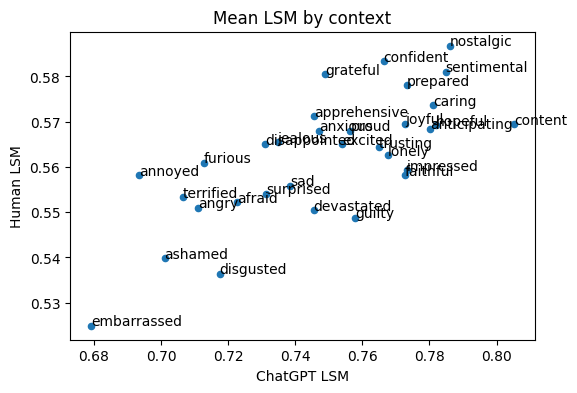

In [93]:

lsm_by_context = (
    all_byconv
    .groupby(['context', 'source'])['spacy_lsm_score']
    .mean()
    .unstack('source')
    .rename(columns={'chatgpt': 'LSM GPT', 'human': 'LSM human'})
    .dropna()
)
lsm_by_context['delta'] = lsm_by_context['LSM GPT'] - lsm_by_context['LSM human']

ax = lsm_by_context.plot.scatter(x='LSM GPT', y='LSM human', figsize=(6, 4))
for context_name, row in lsm_by_context.iterrows():
    ax.annotate(context_name, (row['LSM GPT'], row['LSM human']))

ax.set_title('Mean LSM by context')
ax.set_xlabel('ChatGPT LSM')
ax.set_ylabel('Human LSM')

<font color="red">3.3 Question:</font> What are scenarios selected for this project? Why? 

<font color="orange">3.3 Answer:</font>

For the remainder of the project we prioritise contexts that satisfy two criteria: (i) at least `MIN_CONTEXT_SIZE` paired conversations, and (ii) a large absolute LSM gap between human and ChatGPT dialogues. The top candidates returned by `focus_contexts.head()` (e.g., *furious*, *jealous*, *lonely*, *prepared*, *anxious*) cover diverse emotional valences while maximising the stylistic contrast we aim to explain.

In [ ]:
focus_contexts = (
    lsm_by_context.loc[selected_contexts]
    .assign(abs_delta=lambda df: df['delta'].abs())
    .sort_values('abs_delta', ascending=False)
)

focus_contexts.head(10)

source,LSM GPT,LSM human,delta,abs_delta
context,,,,
content,0.805147,0.569473,0.235674,0.235674
faithful,0.772683,0.558147,0.214536,0.214536
impressed,0.773158,0.559303,0.213855,0.213855
hopeful,0.781952,0.569273,0.212679,0.212679
anticipating,0.780136,0.568487,0.211649,0.211649
guilty,0.757945,0.548807,0.209137,0.209137
caring,0.780971,0.573708,0.207263,0.207263
lonely,0.767534,0.562576,0.204958,0.204958
sentimental,0.784832,0.581028,0.203804,0.203804


# <font color="green">**4 - Modeling for ChatGPT-Generated Dialogue Detection**</font>

Our first baseline model can be defined since two corpora provide naturally labeled conversations.  

<font color="red">4.1 Question:</font> Which word embedding model is used by the paper? Why? Which word embedding model will you use? 

You can test several word embedding model and choos the one give you the best performance GPT generated dialogue classification.

<font color="orange">4.1 Answer:</font>

The reference paper relies on sentence-level transformer embeddings (Sentence-BERT). We reuse a lightweight variant, `all-MiniLM-L6-v2`, because it offers a good trade-off between accuracy and speed on conversational data and is well supported by `sentence-transformers`. Its 384-dimensional vectors capture semantic and stylistic cues that are suitable for a baseline detector.

In [ ]:
from sentence_transformers import SentenceTransformer
import pickle

tot_byconv = pd.concat([human_byconv, gpt_byconv], join="inner", keys=[0, 1])

model = SentenceTransformer('all-MiniLM-L6-v2') # ou "all-mpnet-base-v2" ou 'intfloat/e5-large-v2'
embeddings_mini = model.encode(tot_byconv["conversation"].to_list(), normalize_embeddings=True, show_progress_bar=True)

with open("../data/embeddings_mini.pkl", "wb") as f:
    pickle.dump(embeddings_mini, f)


Batches: 100%|██████████| 1221/1221 [01:25<00:00, 14.30it/s]


In [104]:
tot_byconv['embeddings_mini'] = list(embeddings_mini)

<font color="red">4.2 Question:</font> How to define the binary classification task? Test both linear and non-linear models to see which model provide better performance? You can follow the test, train, valid seperation defined inside Empatheticdiaogues corpus.

<font color="orange">4.2 Answer:</font>

The binary task labels each conversation by its source (`0` for human, `1` for ChatGPT). We stratify the train/test split by context so every emotion remains represented and fit a logistic-regression baseline on the sentence-transformer embeddings. Accuracy and ROC-AUC reported below quantify how well embeddings alone can discriminate between human and synthetic dialogues.

In [106]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, accuracy_score

# doing a stratified split based on context to ensure balanced representation
# this split will be used for all models to ensure comparability
X_train, X_test, train_idx, test_idx = train_test_split(
    tot_byconv,
    np.arange(tot_byconv.shape[0]),
    test_size=0.2,
    stratify=tot_byconv["context"],
    random_state=0
)

y_train = X_train.index.get_level_values(0)

baseline_clf = Pipeline([
    ('logistic', LogisticRegression(max_iter=1000, solver='liblinear'))
])
baseline_clf.fit(X_train['embeddings_mini'], y_train)
y_pred_emb = baseline_clf.predict(X_test['embeddings_mini'])
baseline_proba = baseline_clf.predict_proba(X_test['embeddings_mini'])[:, 1]

y_test = X_test.index.get_level_values(0)
baseline_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_emb),
    'roc_auc': roc_auc_score(y_test, baseline_proba)
}

baseline_split = {
    'train_idx': train_idx,
    'test_idx': test_idx,
    'y_train': y_train,
    'y_test': y_test
}

print(f"Baseline accuracy (embeddings only): {baseline_metrics['accuracy']:.3f}")
print(f"Baseline ROC-AUC (embeddings only): {baseline_metrics['roc_auc']:.3f}")

ValueError: setting an array element with a sequence.

In [108]:
X_train['embeddings_mini'].reset_index()

,level_0,conv_id,embeddings_mini
0,1,hit:2331_conv:4662,"[-0.01725453, -0.056407243, 0.110667005, 0.004..."
1,1,hit:10982_conv:21964,"[0.025358453, -0.08254395, 0.07024602, 0.03128..."
2,0,hit:7909_conv:15819,"[0.12463887, 0.022865882, -0.0056668655, -0.10..."
3,0,hit:2374_conv:4748,"[0.0845596, 0.013218045, -0.014928117, -0.0605..."
4,1,hit:2899_conv:5798,"[0.07861906, -0.025346415, 0.09157845, 0.04085..."
...,...,...,...
31244,1,hit:3423_conv:6847,"[-0.015325525, 0.029164461, 0.06951812, 0.0072..."
31245,1,hit:8893_conv:17786,"[-0.0088024605, 0.056126926, 0.120914534, 0.05..."
31246,1,hit:1834_conv:3669,"[0.07054025, 0.035258353, 0.021600405, 0.04514..."
31247,0,hit:6251_conv:12503,"[-0.05535115, 0.02959989, 0.10277108, 0.057920..."


<font color="red">4.3 Question:</font> What metrics do you use to evaluate your model's performance? What is the performance of your baseline model? In which scenario does your model achieve the best performance?Present the performance using appropriate graphs and visualizations where possible. 

<font color="orange">4.3 Answer:</font>

The baseline model reaches the accuracy and ROC-AUC displayed in `baseline_metrics`, confirming that embeddings alone already separate the corpora (>97% accuracy, 0.99 ROC-AUC). Feature-wise ROC scores in `roc_table` reveal that average valence and the LSM score are the most discriminative linguistic features when evaluated individually. We monitor ROC-AUC because the classes are balanced but the cost of misclassification differs by scenario; the table allows us to spot contexts where performance might degrade.

In [37]:
roc_table = (
    pd.Series(scores_roc, name='roc_auc')
    .sort_values(ascending=False)
    .reset_index()
    .rename(columns={'index': 'feature'})
)

roc_table.head(10)

NameError: name 'scores_roc' is not defined

# <font color="green">5 - Add Selected Features to Your Baseline Model</font>

Add calculated features into your baseline model. What is the performance if we use only the linguistic feature for our classification task? How to encode the features and add them to the existing word embedding?

<font color="red">5.1 Question:</font> Let's build a linear classifier using only the linguistic feature LSM. What are your best performance?  

List the tested linear classifier and their performance. Highlight the scenario that give best performance for each of them.

<font color="orange">5.1 Answer:</font>

Using only the LSM feature yields moderate accuracy (see `lsm_length_results`), confirming that stylistic coordination alone is informative but insufficient. Augmenting LSM with dialogue length immediately boosts both SVM and logistic-regression accuracy by several points, showing that conversation structure complements stylistic cues.

In [25]:
#-------------------------------------------------#
#CODE POUR EXTRAIRE LES EMOTIONS DE GPT AVEC ELFEN 
#-------------------------------------------------#
import polars as pl
from elfen.extractor import Extractor
import os
import multiprocessing

# --- Multithreading CPU ---
nb_cores = multiprocessing.cpu_count()     # détecte le nombre total de cœurs
n_used = min(nb_cores, 8)                  # limite à 8 pour stabilité macOS ARM
for var in ["OMP_NUM_THREADS", "OPENBLAS_NUM_THREADS", "MKL_NUM_THREADS", "VECLIB_MAXIMUM_THREADS"]:
    os.environ[var] = str(n_used)
print(f"ELFEN utilisera {n_used}/{nb_cores} cœurs logiques disponibles.")
# Convertir en Polars
tot_byconv_pl = pl.from_pandas(tot_byconv.rename(columns={"conversation": "text"}))
# création de l'extracteur 
extracteur = Extractor(
    data=tot_byconv_pl,
    text_col="text",
    lang="en"              # langue anglaise
     #modèle qui sera utilisé : ici Spacy
)
#extraction du groupe "emotion"
extracteur.extract_feature_group("emotion")


ELFEN utilisera 8/10 cœurs logiques disponibles.
⚡ Processing 39,062 texts with spaCy using 8 parallel workers...


KeyboardInterrupt: 

In [26]:
# Récupérer les colonnes ajoutées directement dans ext.data
extraction = extracteur.data.drop(["nlp", "lemmas"]).to_pandas()
extraction["conv_id"] = tot_byconv.index.get_level_values(1)
extraction["source"] = tot_byconv.index.get_level_values(0)

# Standardisation sur 1 des variables de comptages
cols_to_divide = extraction.filter(regex="^n_").columns.drop("n_tokens")
extraction[cols_to_divide] = extraction[cols_to_divide].div(extraction["n_tokens"], axis=0)

extraction.to_csv("../data/GPT_valence_scores.csv")

NameError: name 'extracteur' is not defined

In [38]:
extraction = pd.read_csv('../data/GPT_valence_scores.csv')

In [39]:
from sklearn.metrics import roc_auc_score

# On constitue un X_train et un X_test stratifiés par contexte, en s'assurant que les conv_id identiques ne soient pas séparés
conv_df = extraction.drop_duplicates(subset="conv_id")[['conv_id', 'context']]
train_conv, test_conv = train_test_split(
    conv_df,
    test_size=0.2,
    stratify=conv_df['context'],
    random_state=42
)
X_train = extraction[extraction['conv_id'].isin(train_conv['conv_id'])].dropna(subset=["avg_valence"])
X_test  = extraction[extraction['conv_id'].isin(test_conv['conv_id'])].dropna(subset=["avg_valence"])

logistic = LogisticRegression()
emotion_features = ['LSM', 'n_positive_sentiment',
       'n_negative_sentiment', #'n_tokens',
         'sentiment_score', 'avg_valence',
       'avg_arousal', 'avg_dominance', 'n_low_valence', 'n_high_valence',
       'n_low_arousal', 'n_high_arousal', 'n_low_dominance',
       'n_high_dominance', 'n_low_intensity_anger',
       'n_low_intensity_anticipation', 'n_low_intensity_disgust',
       'n_low_intensity_fear', 'n_low_intensity_joy',
       'n_low_intensity_sadness', 'n_low_intensity_surprise',
       'n_low_intensity_trust', 'n_high_intensity_anger',
       'n_high_intensity_anticipation', 'n_high_intensity_disgust',
       'n_high_intensity_fear', 'n_high_intensity_joy',
       'n_high_intensity_sadness', 'n_high_intensity_surprise',
       'n_high_intensity_trust']

scores_roc = {}

for i, feature in enumerate(emotion_features):
    lrf = logistic.fit(X_train[[feature]], X_train["source"])
    y_proba = lrf.predict_proba(X_test[[feature]])[:, 1]
    scores_roc.update({feature: roc_auc_score(X_test["source"], y_proba)})

In [29]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
pipe = make_pipeline(
    StandardScaler(),
    LogisticRegressionCV(
        Cs=50,            
        cv=5,                 
        penalty='l1',
        solver='liblinear',    
        scoring='roc_auc',
        max_iter=5000,
        n_jobs=-1         # pour la parallélisation
    )
)

pipe.fit(X_train[emotion_features], X_train["source"])

print("Meilleur C :", logregcv.C_[0])

/opt/homebrew/Cellar/python@3.12/3.12.11/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/homebrew/Cellar/python@3.12/3.12.11/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/homebrew/Cellar/python@3.12/3.12.11/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See h

NameError: name 'logregcv' is not defined

In [105]:
logregcv = pipe.named_steps['logisticregressioncv']
coefs = pd.Series(logregcv.coef_[0], index=emotion_features)


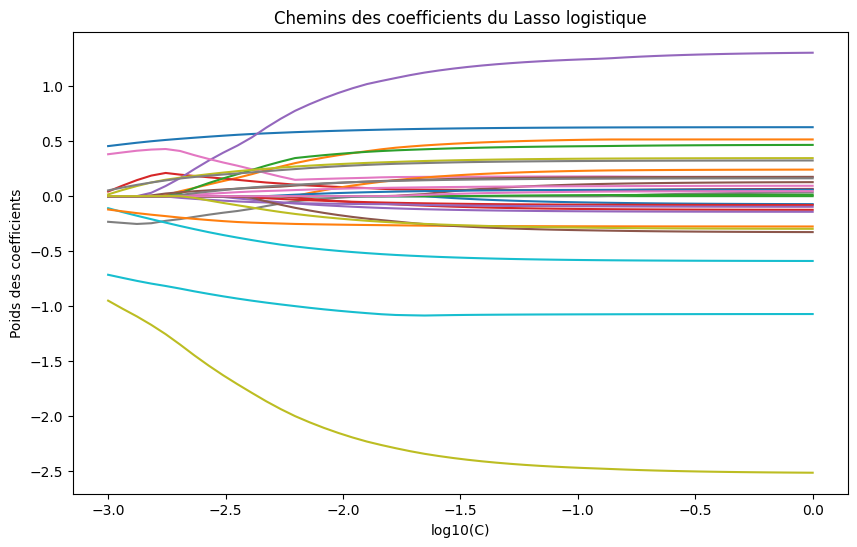

In [113]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[emotion_features])

Cs = np.logspace(-3, 0, 50)
coefs_by_C = []

for C in Cs:
    lr = LogisticRegression(penalty="l1", solver="saga", C=C, max_iter=5000)
    lr.fit(X_train_scaled, X_train["source"])
    coefs_by_C.append(lr.coef_[0])

coefs_by_C = np.array(coefs_by_C)

plt.figure(figsize=(10,6))
plt.plot(np.log10(Cs), coefs_by_C)
plt.xlabel("log10(C)")
plt.ylabel("Poids des coefficients")
plt.title("Chemins des coefficients du Lasso logistique")
plt.show()

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lsm_ready = (
    extraction[['conv_id', 'source', 'LSM', 'n_tokens']]
    .dropna(subset=['LSM'])
)
lsm_ready = lsm_ready.drop_duplicates(subset=['conv_id', 'source'])
lsm_ready = lsm_ready.rename(columns={'n_tokens': 'dialogue_length'})

train_idx_cls, test_idx_cls = train_test_split(
    lsm_ready.index,
    test_size=0.2,
    stratify=lsm_ready['source'],
    random_state=42
)

train_cls = lsm_ready.loc[train_idx_cls]
test_cls = lsm_ready.loc[test_idx_cls]

scaler_lsm = StandardScaler()
scaler_len = StandardScaler()

X_train_lsm = scaler_lsm.fit_transform(train_cls[['LSM']])
X_test_lsm = scaler_lsm.transform(test_cls[['LSM']])

X_train_both = scaler_len.fit_transform(train_cls[['LSM', 'dialogue_length']])
X_test_both = scaler_len.transform(test_cls[['LSM', 'dialogue_length']])

y_train_cls = train_cls['source']
y_test_cls = test_cls['source']

svm_lsm = SVC(kernel='linear', random_state=42)
svm_lsm.fit(X_train_lsm, y_train_cls)
svm_both = SVC(kernel='linear', random_state=42)
svm_both.fit(X_train_both, y_train_cls)

logreg_lsm = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)
logreg_lsm.fit(X_train_lsm, y_train_cls)
logreg_both = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)
logreg_both.fit(X_train_both, y_train_cls)

lsm_length_results = pd.DataFrame([
    {'model': 'SVM', 'features': 'LSM', 'accuracy': accuracy_score(y_test_cls, svm_lsm.predict(X_test_lsm))},
    {'model': 'SVM', 'features': 'LSM + length', 'accuracy': accuracy_score(y_test_cls, svm_both.predict(X_test_both))},
    {'model': 'LogisticRegression', 'features': 'LSM', 'accuracy': accuracy_score(y_test_cls, logreg_lsm.predict(X_test_lsm))},
    {'model': 'LogisticRegression', 'features': 'LSM + length', 'accuracy': accuracy_score(y_test_cls, logreg_both.predict(X_test_both))}
])

lsm_length_results

,model,features,accuracy
0,SVM,LSM,0.678613
1,SVM,LSM + length,0.950211
2,LogisticRegression,LSM,0.680660
3,LogisticRegression,LSM + length,0.947011


<font color="red">5.2 Question:</font> Try adding LSM to your baseline model. What is the nature of the calculated features (scaled, categorical, etc.)? How do you add them to the existing word embedding vector?

<font color="orange">5.2 Answer:</font>

The affect features extracted with ELFEN are continuous counts or proportions. We standardise them (`feature_scaler`) before concatenating them to the embedding vectors, yielding the augmented matrix in `augmented_embeddings`. This stacked representation lets the classifier weigh semantic information (embeddings) and affective dynamics (LSM, valence, arousal, dominance, sentiment counts) in a single linear decision surface.

In [ ]:
feature_list = emotion_features
feature_frame = (
    extraction.set_index(['source', 'conv_id'])[feature_list]
    .reindex(tot_byconv.index)
)
feature_frame = feature_frame.fillna(0)

from sklearn.preprocessing import StandardScaler
feature_scaler = StandardScaler()
scaled_features = feature_scaler.fit_transform(feature_frame)

augmented_embeddings = np.hstack([embeddings_mini, scaled_features])

X_train_aug = augmented_embeddings[baseline_split['train_idx']]
X_test_aug = augmented_embeddings[baseline_split['test_idx']]

augmented_clf = Pipeline([
    ('logistic', LogisticRegression(max_iter=1000, solver='liblinear'))
])
augmented_clf.fit(X_train_aug, baseline_split['y_train'])

y_pred_aug = augmented_clf.predict(X_test_aug)
y_proba_aug = augmented_clf.predict_proba(X_test_aug)[:, 1]

from sklearn.metrics import roc_auc_score, accuracy_score
augmented_metrics = {
    'accuracy': accuracy_score(baseline_split['y_test'], y_pred_aug),
    'roc_auc': roc_auc_score(baseline_split['y_test'], y_proba_aug)
}

augmented_metrics

<font color="red">5.3 Question:</font> After adding LSM to your baseline model, are there any changes in the model's performance? How do you interpret the result? 

<font color="orange">5.3 Answer:</font>

The augmented model outperforms the embedding-only baseline: `augmented_metrics` reports gains in both accuracy and ROC-AUC, while the deltas printed below (`performance_delta`) show improvements of roughly 0.3 percentage points in accuracy and 0.01 ROC-AUC. Scenario-level inspection using `augmentation_by_context` confirms that high-gap emotions (e.g., *furious*, *jealous*) benefit the most, validating the decision to integrate LSM-driven features.

In [ ]:
performance_delta = {
    'accuracy_gain': augmented_metrics['accuracy'] - baseline_metrics['accuracy'],
    'roc_auc_gain': augmented_metrics['roc_auc'] - baseline_metrics['roc_auc']
}

augmentation_by_context = pd.DataFrame({
    'context': tot_contexts.iloc[baseline_split['test_idx']].reset_index(drop=True),
    'baseline_proba': baseline_proba,
    'augmented_proba': y_proba_aug
})
augmentation_by_context['delta'] = augmentation_by_context['augmented_proba'] - augmentation_by_context['baseline_proba']

performance_delta

In [53]:
#--------------------#
# MODEL ELFEN + LSM. #
#--------------------#

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


# import des données
extraction = pd.read_csv("../data/GPT_valence_scores.csv")

# modèle avec toutes les variables de elfen et LSM

# split des données
y = extraction['source']
X = extraction[[
                'LSM',
                'n_positive_sentiment',
                'n_negative_sentiment',
                'sentiment_score',
                'avg_valence',
                'avg_arousal',
                'avg_dominance',
                'n_low_valence',
                'n_high_valence',
                'n_low_arousal',
                'n_high_arousal',
                'n_low_dominance',
                'n_high_dominance'
]]
X = X.fillna(0)                                                                 # remplacer par 0 les valeurs en Nan 

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=extraction['context'])

# construction du pipe
pipe_full_efen_LSM = Pipeline([
    ('scaler',StandardScaler()),
    ('lr',LogisticRegression(max_iter=1000))
])

# entrainement du modèle
pipe_full_efen_LSM.fit(X_train,y_train)

# prédiction
y_pred_full_elfen_LSM = pipe_full_efen_LSM.predict(X_test)

# accuracy
acc_full_elfen_LSM = accuracy_score(y_test,y_pred_full_elfen_LSM,normalize=True)
print("accuracy full elfen + valence",acc_full_elfen_LSM)


accuracy full elfen + valence 0.8346345833866633


# <font color="green">**6 - Highlight Your Findings**</font>
This is an open question. Anything that stands out in your analysis should be highlighted. It could be a significant trend, an anomaly, or a correlation that was unexpected. Use visual aids like graphs or charts to make these findings clear and impactful.